---
CSC 268 Final Project:  SIFT Copy Move Forgery Detection 
---

This assignment is an extension of our discussions on the SIFT (Scale-Invariant Feature Transform) algorithm. The goal is to implement a copy-move forgery detector that can automatically identify duplicated regions within images. Copy-move forgeries occur when a portion of an image is copied and pasted elsewhere in the same image, often to manipulate or misrepresent content. Using SIFT, this project explores how feature detection, matching, and clustering can be used to detect these forgeries in a dataset of biomedical images.

## Set Up Environment

In [170]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import glob
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import DBSCAN

def imshow(img,cmap=None):
    plt.imshow(img,cmap=cmap,interpolation='none')
    plt.axis('off')
    plt.show()

# Root directory for dataset
DATA_ROOT = Path("/Users/rowusupoku/CSC 334/Final Project/")

# Extracted dataset directory
ZIP_DIR = DATA_ROOT / "recodai-luc"

# Dataset subdirectories
TRAIN_IMG_DIR = ZIP_DIR / "train_images"

# Output directory for SIFT masks
OUTPUT_DIR = ZIP_DIR / "sift_masks"

train_image_paths = sorted(TRAIN_IMG_DIR.glob("*/*.png"))
print("Train images found:", len(train_image_paths))

Train images found: 5128


## SIFT Preprocessing and Feature Detection

In [171]:
# Function takes an image and converts it to grayscale 
def sift_preprocessing(img_path):
    img = cv.imread(str(img_path))
    if img is None:
        return None
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return cv.equalizeHist(img)
    
# Function performs SIFT on image, detecting keypoints and descriptors
def detect_sift(img_gray):
    sift = cv.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)
    return keypoints, descriptors

## Feature matching 

In [133]:
# This function compares the image descriptors to itself to find similar features
def match_sift(desc, keypoints, min_dist=5):
    if desc is None or len(desc) < 2:
        return []
    #Performs matching
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=False)
    matches = bf.knnMatch(desc, desc, k=2)

    good_matches = []
    for m, n in matches:
            if m.queryIdx != m.trainIdx:
                pt1 = np.array(keypoints[m.queryIdx].pt)
                pt2 = np.array(keypoints[m.trainIdx].pt)
                # Only keep matches that are far apart
                if np.linalg.norm(pt1 - pt2) > min_dist:
                    good_matches.append(m)
    return good_matches

## RANSAC filtering (Filer Mismatches)

In [144]:
#Function filters matches using RANSAC and returns coordinates
def ransac_filter(kp, matches):
    if len(matches) < 4:
        # Return empty arrays instead of None
        return np.array([]), np.array([])

    pts1 = np.float32([kp[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp[m.trainIdx].pt for m in matches])

    H, mask = cv.findHomography(pts1, pts2, cv.RANSAC, 5.0)

    if mask is None:
        return np.array([]), np.array([])

    mask = mask.ravel().astype(bool)
    return pts1[mask], pts2[mask]

## Clustering Matches (Region Clustering)

In [145]:
def cluster_matches(pts, eps=20, min_samples=3):
    if len(pts) == 0:
        return np.array([])

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(pts)
    labels = db.labels_
    return labels

## Binary Forgery Mask

In [146]:
def create_mask_from_clusters(shape, pts, labels):
    mask = np.zeros(shape, dtype=np.uint8)
    for label in set(labels):
        if label == -1:
            continue
        cluster_pts = pts[labels == label]
        for (x, y) in cluster_pts:
            cv.circle(mask, (int(x), int(y)), 5, 255, -1)
    return mask

## Results (On a single Image)

Number of matches after RANSAC: 1025


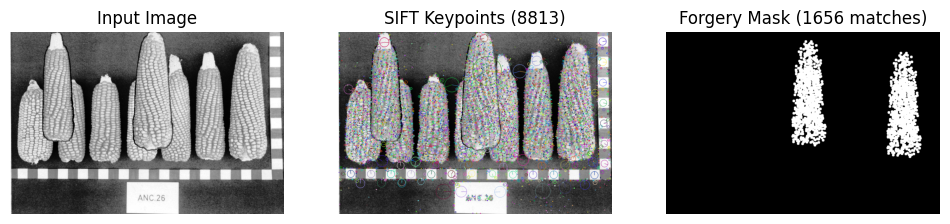

In [172]:
# Select training image

# Forged Image
img_path = train_image_paths[3005]

# Authentic Image
#img_path = img_path = train_image_paths[30]

# Random Image
# img_path = random.choice(train_image_paths)


# Load image
gray = sift_preprocessing(img_path)

# Run SIFT
kp, desc = detect_sift(gray)

# Match descriptors
matches = match_sift(desc, kp, min_dist=5)

# RANSAC filtering
pts1, pts2 = ransac_filter(kp, matches)
print("Number of matches after RANSAC:", len(pts1))

# Combine points for clustering
all_pts = np.vstack([pts1, pts2]) if len(pts1) > 0 else np.array([])

# DBSCAN clustering
labels = cluster_matches(all_pts, eps=20, min_samples=3)

# Create forgery mask from clusters
forgery_mask = create_mask_from_clusters(gray.shape, all_pts, labels)

# Visualization
plt.figure(figsize=(12,4))

# Original image
plt.subplot(1,3,1)
plt.imshow(gray, cmap="gray")
plt.title("Input Image")
plt.axis("off")

# SIFT keypoints
plt.subplot(1,3,2)
kp_img = cv.drawKeypoints(
    gray,
    kp,
    None,
    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.imshow(kp_img, cmap="gray")
plt.title(f"SIFT Keypoints ({len(kp)})")
plt.axis("off")

# Forgery mask
plt.subplot(1,3,3)
plt.imshow(forgery_mask, cmap="gray")
plt.title(f"Forgery Mask ({len(matches)} matches)")
plt.axis("off")

plt.show()

Now that the SIFT-based forgery detector can identify forgery in individual images, the next step would be to run the algorithm on the full dataset to generate masks for all images. After generating these masks, they could be compiled into a submission CSV for evaluation. With more time, parameters could also be tuned to improve match detection and mask accuracy across the dataset.

## Sources

-Ramu, Gonapalli, and S. B. G. Thilak Babu. “Image Forgery Detection for High Resolution Images Using SIFT and RANSAC Algorithm.” 2017 2nd International Conference on Communication and Electronics Systems (ICCES), IEEE, 2017, doi:10.1109/cesys.2017.8321205.
-Rando, Halie. Lab5 UNet Forgery Detection 
-Jain, Himanshu. "Copy Move Forgery Detection using SIFT and DBSCAN clustering." 2020, https://medium.com/analytics-vidhya/copy-move-forgery-detection-using-sift-and-dbscan-clustering-4a179c36293e